In [1]:
# pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [45]:
import os
import time
import uuid
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import json
import numpy as np
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [4]:
images.as_numpy_iterator().next()

b'data\\images\\2f4a5870-a3e7-11ed-b2bc-48ba4e89b37b.jpg'

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_image)

In [7]:
images.as_numpy_iterator().next()

array([[[132, 135, 108],
        [132, 134, 110],
        [132, 134, 112],
        ...,
        [191, 190, 206],
        [193, 190, 207],
        [194, 191, 208]],

       [[130, 134, 109],
        [130, 134, 111],
        [130, 133, 112],
        ...,
        [189, 188, 202],
        [191, 189, 203],
        [191, 189, 203]],

       [[130, 135, 115],
        [130, 135, 115],
        [130, 134, 117],
        ...,
        [189, 189, 201],
        [189, 189, 201],
        [189, 189, 201]],

       ...,

       [[154, 107,  63],
        [153, 106,  60],
        [152, 108,  63],
        ...,
        [121, 129, 106],
        [119, 129, 105],
        [117, 130, 104]],

       [[150, 106,  59],
        [149, 105,  56],
        [150, 106,  59],
        ...,
        [123, 129, 103],
        [119, 130, 100],
        [117, 131,  98]],

       [[149, 105,  56],
        [148, 104,  55],
        [149, 105,  56],
        ...,
        [122, 129,  98],
        [119, 130,  98],
        [117, 131,  96]]

In [8]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

In [11]:
plot_images = image_generator.next()

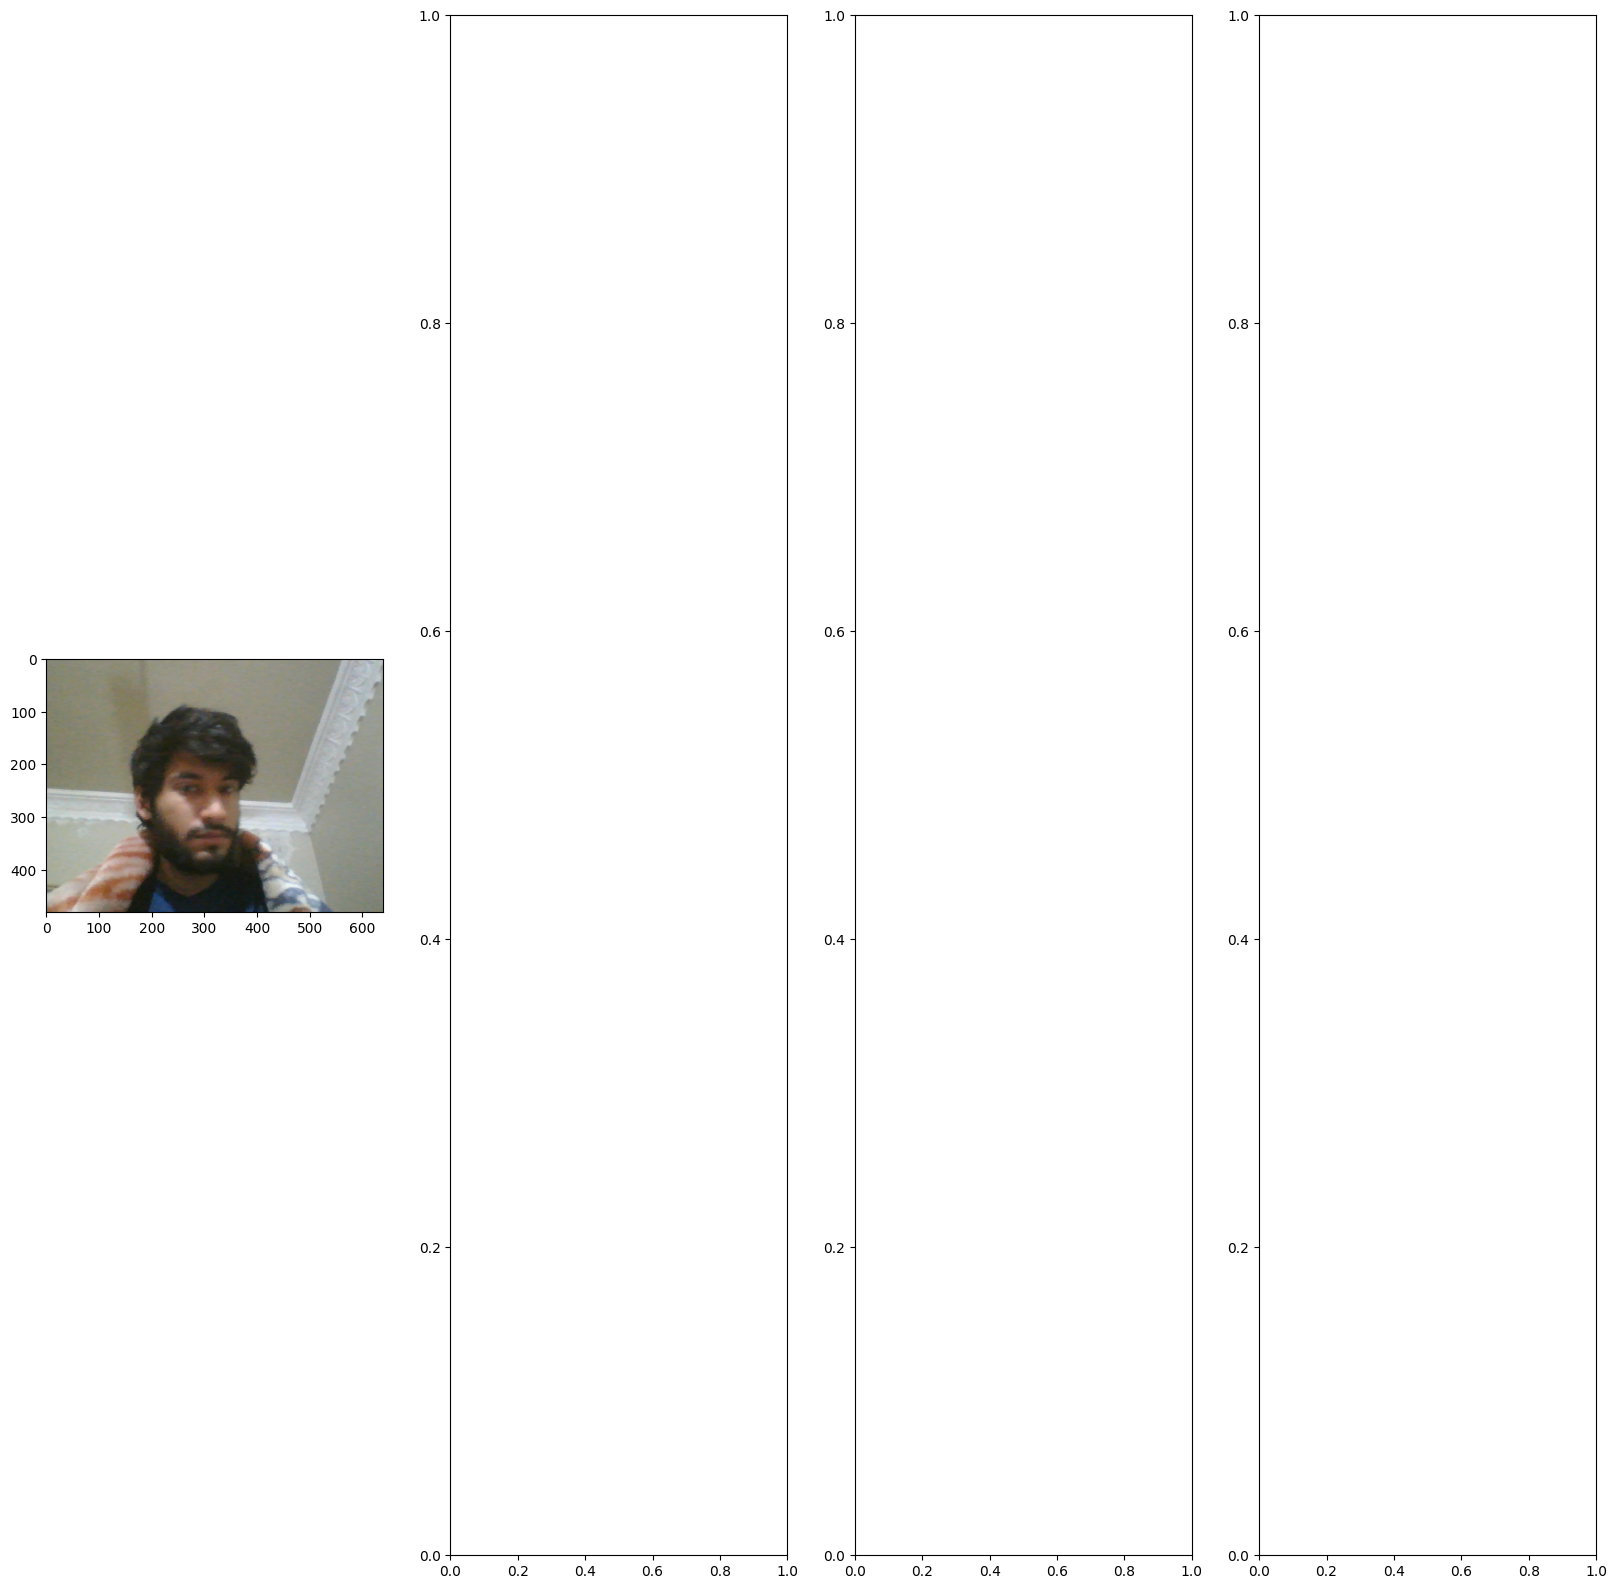

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [13]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [14]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [15]:
img = cv2.imread(os.path.join('data','train', 'images','2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.jpg'))

In [16]:
with open(os.path.join('data', 'train', 'labels', '2ef7f7c4-a3e7-11ed-bf4c-48ba4e89b37b.json'), 'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[175.3639846743295, 92.68199233716474],
 [414.0613026819923, 427.16475095785444]]

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[175.3639846743295, 92.68199233716474, 414.0613026819923, 427.16475095785444]

In [20]:
coords = list(np.divide(coords, [640,480,640,480]))

In [21]:
coords

[0.27400622605363983,
 0.19308748403575987,
 0.6469707854406129,
 0.8899265644955301]

In [22]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
augmented['bboxes'][0][2:]

(0.49791400595998286, 0.8495955725840784)

In [24]:
augmented['bboxes']

[(0.0, 0.10630055342699019, 0.49791400595998286, 0.8495955725840784)]

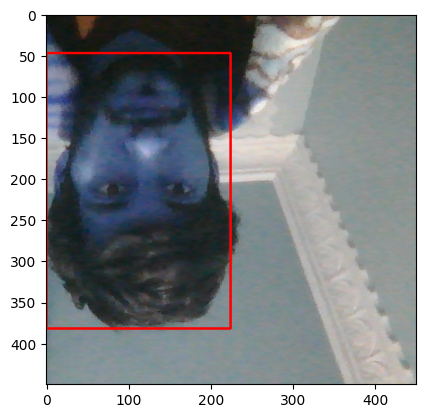

In [25]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [26]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'Images')):
        img = cv2.imread(os.path.join('data', partition, 'Images', image))
        
        # print(os.path.join('data', partition, 'Images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
            # print(coords)
            
            
            

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # xs = os.path.join('aug_data', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg')
                # print(xs)
                cv2.imwrite(os.path.join('data/aug_data', partition, 'Images', f'{image.split(".")[0]}-{x}.jpg'), augmented['image'])
                

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    # print("True")
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                xname = os.path.join('data/aug_data', partition, 'labels', f'{image.split(".")[0]}-{x}.json')
                # print(xname)
                with open(xname, "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2488625478927203, 0.18670178799489143, 0.0, 0.8181336254048315, 'face'].
x_max is less than or equal to x_min for bbox [0.348838601532567, 0.17871966794380587, 4.4408920985006264e-17, 0.8074404032641301, 'face'].
x_max is less than or equal to x_min for bbox [0.32848419540229884, 0.1795178799489144, 0.0, 0.8275080931013993, 'face'].
x_max is less than or equal to x_min for bbox [0.43803879310344823, 0.006305874840357582, 8.881784197001253e-17, 0.8221241561758801, 'face'].
x_max is less than or equal to x_min for bbox [0.15607040229885055, 0.10209131545338442, 0.0, 0.8886550842530642, 'face'].
x_max is less than or equal to x_min for bbox [0.21414032567049807, 0.008700510855683252, 4.4408920985006264e-17, 0.8901882006527598, 'face'].
x_max is less than or equal to x_min for bbox [0.6763050766283525, 0.010296934865900366, 0.34105603448275856, 0.5339240102171137, 'face'].
x_max is less than or equal to x_min for bbox [0.6715158045977011, 0.

In [27]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [29]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [30]:
train_images.as_numpy_iterator().next()

array([[[0.7088848 , 0.73835784, 0.77610296],
        [0.7119485 , 0.728125  , 0.78253675],
        [0.69166666, 0.70998776, 0.7579657 ],
        ...,
        [0.53272057, 0.5357843 , 0.41960785],
        [0.52463233, 0.5264706 , 0.45441177],
        [0.5172794 , 0.5121936 , 0.45814952]],

       [[0.69215685, 0.7343137 , 0.75894606],
        [0.68719363, 0.7284926 , 0.7529412 ],
        [0.68106616, 0.7173407 , 0.7511642 ],
        ...,
        [0.5251225 , 0.5181373 , 0.42849264],
        [0.52892154, 0.52457106, 0.4452206 ],
        [0.52530634, 0.5192402 , 0.453799  ]],

       [[0.7094976 , 0.71047795, 0.75753677],
        [0.7049632 , 0.7182598 , 0.7452206 ],
        [0.67971814, 0.71936274, 0.7280637 ],
        ...,
        [0.533701  , 0.514277  , 0.4357843 ],
        [0.52254903, 0.5147059 , 0.42463234],
        [0.5257966 , 0.5216912 , 0.4081495 ]],

       ...,

       [[0.4860907 , 0.4978554 , 0.46844363],
        [0.48670343, 0.49846813, 0.46905637],
        [0.5009804 , 0

In [31]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [32]:
train_labels = tf.data.Dataset.list_files('data\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [33]:
test_labels = tf.data.Dataset.list_files('data\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:
val_labels = tf.data.Dataset.list_files('data\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.423 , 0.1561, 0.94  , 0.885 ], dtype=float16))

In [36]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4320, 4320, 960, 960, 1020, 1020)

In [37]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [38]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [39]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [40]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.1569, 0.1412, 0.637 , 0.9033],
        [0.    , 0.4524, 0.4717, 0.9897],
        [0.    , 0.    , 0.5933, 0.976 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3564, 0.0161, 0.8936, 0.5464],
        [0.2834, 0.123 , 0.901 , 0.802 ],
        [0.19  , 0.    , 0.7373, 0.409 ]], dtype=float16))

In [41]:
data_samples = train.as_numpy_iterator()

In [42]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


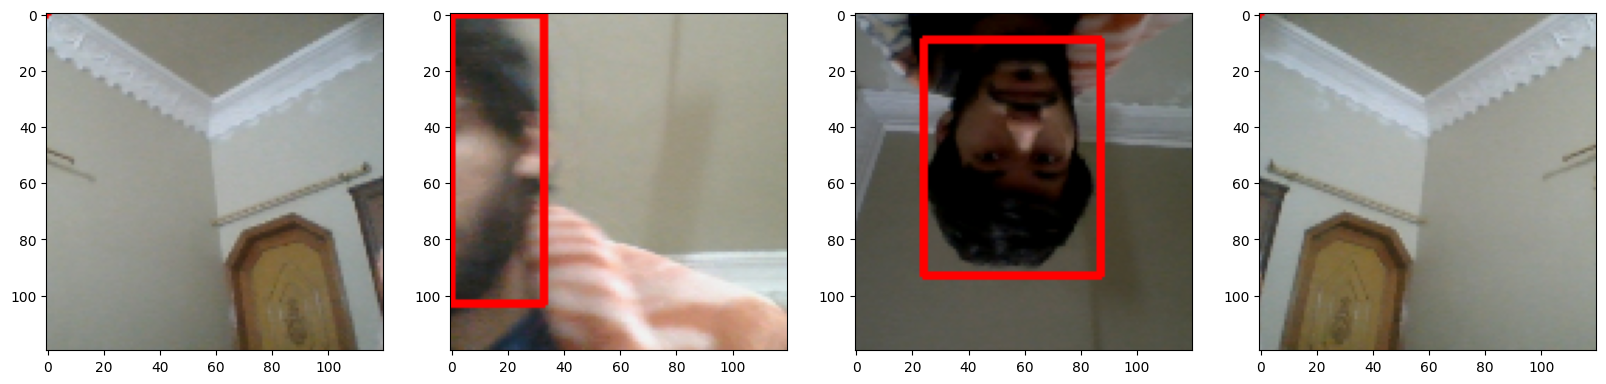

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [46]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 39s 1us/step


In [47]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [49]:
facetracker = build_model()

In [50]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [51]:
X, y = train.as_numpy_iterator().next()

In [52]:
X.shape

(8, 120, 120, 3)

In [53]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [54]:
classes, coords

(array([[0.54933244],
        [0.6217659 ],
        [0.5907538 ],
        [0.5232799 ],
        [0.5769081 ],
        [0.50402033],
        [0.5829259 ],
        [0.57056916]], dtype=float32),
 array([[0.47404423, 0.34356403, 0.62357134, 0.4956898 ],
        [0.45862725, 0.29127428, 0.5586885 , 0.5196405 ],
        [0.5785288 , 0.3513433 , 0.54403794, 0.52296805],
        [0.5027385 , 0.35303453, 0.5108805 , 0.4811277 ],
        [0.5111956 , 0.2977413 , 0.5465459 , 0.42448437],
        [0.5335154 , 0.35026583, 0.5266975 , 0.49291956],
        [0.46892995, 0.3265329 , 0.47479516, 0.39240602],
        [0.46628255, 0.3859982 , 0.58457965, 0.4873759 ]], dtype=float32))